# Estimation of Navier-Stokes equation
## Done by: Andreea-Ioana Florea

In [102]:
!pip install tensorflow_probability deepxde

In [103]:
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt

In [104]:
# Channel dimensions
x_min, x_max = -2.5, 2.5
y_min, y_max = -0.5, 0.5

# Throat block parameters (two rectangles on the left)
throat_x_min, throat_x_max = -1.8, -1.1
throat_top_y_min, throat_top_y_max = 0.15, 0.5
throat_bot_y_min, throat_bot_y_max = -0.5, -0.15

# Obstacle cylinder parameters
cyl_radius = 0.06

In [105]:
# Main channel
channel = dde.geometry.Rectangle([x_min, y_min], [x_max, y_max])

# Throat blocks (solid rectangles that will be excluded)
throat_top = dde.geometry.Rectangle([throat_x_min, throat_top_y_min],
                                    [throat_x_max, throat_top_y_max])

throat_bot = dde.geometry.Rectangle([throat_x_min, throat_bot_y_min],
                                    [throat_x_max, throat_bot_y_max])

# Start with channel, then remove throat blocks
geom = channel - throat_top - throat_bot

In [106]:
# Generate staggered cylinder centers
# Two staggered rows in y, repeated in x
x_centers = np.linspace(-0.9, 2.1, 10)
y_rows = [0.3, 0.1, -0.1, -0.3]

centers = []
for i, x in enumerate(x_centers):
    for j, y in enumerate(y_rows):
        # Stagger every other column
        if i % 2 == 0 and j % 2 == 0:
            centers.append([x, y])
        elif i % 2 == 1 and j % 2 == 1:
            centers.append([x, y])

centers = np.array(centers)

In [107]:
# Build cylinder union
cyl_union = dde.geometry.Disk(centers[0], cyl_radius)
for c in centers[1:]:
    cyl_union = cyl_union | dde.geometry.Disk(c, cyl_radius)

# Single subtraction (much faster)
geom = channel - throat_top - throat_bot - cyl_union

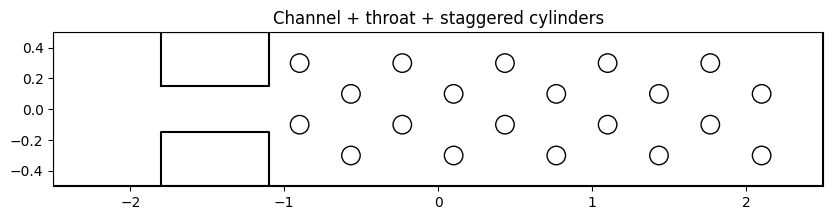

In [108]:
fig, ax = plt.subplots(figsize=(10, 2))

# Plot channel boundary
ax.plot([x_min, x_max, x_max, x_min, x_min],
        [y_min, y_min, y_max, y_max, y_min], 'k')

# Plot throat blocks
ax.plot([throat_x_min, throat_x_max, throat_x_max, throat_x_min, throat_x_min],
        [throat_top_y_min, throat_top_y_min, throat_top_y_max, throat_top_y_max, throat_top_y_min], 'k')
ax.plot([throat_x_min, throat_x_max, throat_x_max, throat_x_min, throat_x_min],
        [throat_bot_y_min, throat_bot_y_min, throat_bot_y_max, throat_bot_y_max, throat_bot_y_min], 'k')

# Plot cylinders
for c in centers:
    circle = plt.Circle(c, cyl_radius, fill=False, color='k')
    ax.add_patch(circle)

ax.set_aspect('equal')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_title("Channel + throat + staggered cylinders")
plt.show()

In [109]:
# Time domain
t0, t1 = 0.0, 5.0
timedomain = dde.geometry.TimeDomain(t0, t1)

# Space-time geometry
geom_time = dde.geometry.GeometryXTime(geom, timedomain)

In [110]:
# Kinematic viscosity
nu = 0.01

def navier_stokes_pde(x, y):
    # y = [u, v, p]
    u = y[:, 0:1]
    v = y[:, 1:2]
    p = y[:, 2:3]

    u_t = dde.grad.jacobian(y, x, i=0, j=2)
    v_t = dde.grad.jacobian(y, x, i=1, j=2)

    u_x = dde.grad.jacobian(y, x, i=0, j=0)
    u_y = dde.grad.jacobian(y, x, i=0, j=1)
    v_x = dde.grad.jacobian(y, x, i=1, j=0)
    v_y = dde.grad.jacobian(y, x, i=1, j=1)

    u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    u_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)
    v_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    v_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)

    p_x = dde.grad.jacobian(y, x, i=2, j=0)
    p_y = dde.grad.jacobian(y, x, i=2, j=1)

    # Momentum equations
    eq1 = u_t + u * u_x + v * u_y + p_x - nu * (u_xx + u_yy)
    eq2 = v_t + u * v_x + v * v_y + p_y - nu * (v_xx + v_yy)

    # Continuity equation
    eq3 = u_x + v_y

    return [eq1, eq2, eq3]

In [111]:
def inlet_boundary(x, on_boundary):
    return on_boundary and np.isclose(x[0], x_min)

def outlet_boundary(x, on_boundary):
    return on_boundary and np.isclose(x[0], x_max)

def wall_boundary(x, on_boundary):
    return on_boundary and (np.isclose(x[1], y_min) or np.isclose(x[1], y_max))

def obstacle_boundary(x, on_boundary):
    # Mark any boundary point that is not inlet/outlet/walls as obstacle
    if not on_boundary:
        return False
    if inlet_boundary(x, True) or outlet_boundary(x, True) or wall_boundary(x, True):
        return False
    return True

In [112]:
# Inlet: parabolic profile (example)
def inlet_u(x):
    y = x[:, 1:2]
    return 4.0 * (y - y_min) * (y_max - y) / (y_max - y_min) ** 2

def inlet_v(x):
    return 0.0

bc_inlet_u = dde.DirichletBC(geom_time, inlet_u, inlet_boundary, component=0)
bc_inlet_v = dde.DirichletBC(geom_time, inlet_v, inlet_boundary, component=1)

# Outlet: pressure = 0
bc_outlet_p = dde.DirichletBC(geom_time, lambda x: 0, outlet_boundary, component=2)

# Walls + obstacles: no-slip
bc_wall_u = dde.DirichletBC(geom_time, lambda x: 0, wall_boundary, component=0)
bc_wall_v = dde.DirichletBC(geom_time, lambda x: 0, wall_boundary, component=1)

bc_obs_u = dde.DirichletBC(geom_time, lambda x: 0, obstacle_boundary, component=0)
bc_obs_v = dde.DirichletBC(geom_time, lambda x: 0, obstacle_boundary, component=1)

In [113]:
# Initial condition: zero velocity, zero pressure
ic_u = dde.IC(geom_time, lambda x: 0, lambda _, on_initial: on_initial, component=0)
ic_v = dde.IC(geom_time, lambda x: 0, lambda _, on_initial: on_initial, component=1)
ic_p = dde.IC(geom_time, lambda x: 0, lambda _, on_initial: on_initial, component=2)

In [114]:
data = dde.data.TimePDE(
    geom_time,
    navier_stokes_pde,
    [bc_inlet_u, bc_inlet_v, bc_outlet_p, bc_wall_u, bc_wall_v, bc_obs_u, bc_obs_v, ic_u, ic_v, ic_p],
    num_domain=5000,
    num_boundary=1000,
    num_initial=1000,
    num_test=1000,
)

In [115]:
# Define neural network
net = dde.nn.FNN([3] + [64] * 5 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)

In [ ]:
# Compile and train
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(epochs=20000)

# Fine-tune with L-BFGS for better convergence
model.compile("L-BFGS")
losshistory, train_state = model.train(iterations=5000)

Compiling model...
'compile' took 0.171671 s

Training model...

Step      Train loss                                                                                                                            Test loss                                                                                                                             Test metric
0         [8.97e-02, 2.32e-03, 1.56e-02, 5.40e-01, 4.32e-02, 2.57e-01, 3.42e-03, 3.42e-02, 6.07e-03, 1.97e-02, 4.52e-03, 2.04e-03, 3.22e-01]    [8.84e-02, 2.19e-03, 1.34e-02, 5.40e-01, 4.32e-02, 2.57e-01, 3.42e-03, 3.42e-02, 6.07e-03, 1.97e-02, 4.52e-03, 2.04e-03, 3.22e-01]    []  
1000      [2.92e-03, 5.34e-04, 8.33e-03, 5.57e-03, 2.18e-03, 7.23e-06, 6.14e-04, 3.29e-03, 5.73e-03, 9.93e-04, 2.58e-03, 2.28e-04, 3.06e-04]    [1.28e-03, 2.59e-04, 6.64e-03, 5.57e-03, 2.18e-03, 7.23e-06, 6.14e-04, 3.29e-03, 5.73e-03, 9.93e-04, 2.58e-03, 2.28e-04, 3.06e-04]    []  


In [ ]:
plt.plot(losshistory.loss_train)
plt.show()